In [1]:
# 📚 Entrenamiento de Red Neuronal CNN para clasificación multiclase

# 🔧 Cargar librerías
import os
import sys
import yaml
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

C:\Users\USS\anaconda3\envs\tf310\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
# Ajustar path para importar módulos locales
sys.path.append("../src")
import model
import utils
import train

In [3]:
# 🔧 Cargar configuración
with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)

img_height = config["image"]["height"]
img_width = config["image"]["width"]
batch_size = config["training"]["batch_size"]
epochs = config["training"]["epochs"]
data_path = config["paths"]["prepared_data"]
model_path = config["paths"]["model"]

In [4]:
# 📦 Cargar datos
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,   # ← en vez de rescale
    rotation_range=15, width_shift_range=0.1, height_shift_range=0.1,
    shear_range=0.1, zoom_range=0.15, horizontal_flip=True, fill_mode="nearest"
)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    os.path.join(data_path, "train"),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(data_path, "val"),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False   
)

Found 1592 images belonging to 54 classes.
Found 355 images belonging to 54 classes.


In [5]:
# ✅ Verificar consistencia de clases
assert train_generator.class_indices == val_generator.class_indices
num_classes = len(train_generator.class_indices)

In [6]:
# Calcular class_weight balanceado
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))
print("Pesos por clase:", class_weight_dict)

Pesos por clase: {0: np.float64(0.6551440329218107), 1: np.float64(0.49968612680477087), 2: np.float64(0.49968612680477087), 3: np.float64(0.737037037037037), 4: np.float64(0.45356125356125354), 5: np.float64(0.7559354226020892), 6: np.float64(0.8933782267115601), 7: np.float64(0.8189300411522634), 8: np.float64(0.6409017713365539), 9: np.float64(0.951015531660693), 10: np.float64(0.67003367003367), 11: np.float64(1.474074074074074), 12: np.float64(1.1792592592592592), 13: np.float64(0.9212962962962963), 14: np.float64(1.5516569200779726), 15: np.float64(1.2818035426731078), 16: np.float64(1.474074074074074), 17: np.float64(1.1339031339031338), 18: np.float64(1.4038800705467371), 19: np.float64(1.9654320987654321), 20: np.float64(1.8425925925925926), 21: np.float64(2.948148148148148), 22: np.float64(1.016602809706258), 23: np.float64(1.8425925925925926), 24: np.float64(0.8671023965141612), 25: np.float64(0.9827160493827161), 26: np.float64(0.8423280423280424), 27: np.float64(1.05291005

In [7]:
# 🧠 Construir modelo
cnn_model = model.build_model_transfer(config, num_classes)

cnn_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step 


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 54)                  │          69,174 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,327,158 (8.88 MB)

 Trainable params: 69,174 (270.21 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
# 🏋️ Entrenar el modelo
callbacks = [
    EarlyStopping(monitor="val_loss", patience=config["training"]["patience"], restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint(filepath="models/cnn_multiclass_v2.keras", monitor="val_loss", save_best_only=True)
]

history = cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=callbacks,
    class_weight=class_weight_dict  # ← aquí se aplican
)

C:\Users\USS\anaconda3\envs\tf310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 46s 737ms/step - accuracy: 0.1179 - loss: 3.9935 - val_accuracy: 0.3915 - val_loss: 2.0853 - learning_rate: 0.0010
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 34s 668ms/step - accuracy: 0.6063 - loss: 1.5383 - val_accuracy: 0.6197 - val_loss: 1.4135 - learning_rate: 0.0010
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 662ms/step - accuracy: 0.7685 - loss: 0.8749 - val_accuracy: 0.6592 - val_loss: 1.2216 - learning_rate: 0.0010
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 639ms/step - accuracy: 0.8319 - loss: 0.6397 - val_accuracy: 0.6789 - val_loss: 1.0750 - learning_rate: 0.0010
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 663ms/step - accuracy: 0.8786 - loss: 0.4751 - val_accuracy: 0.7211 - val_loss: 0.9816 - learning_rate: 0.0010
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 658ms/step - accuracy: 0.9022 - loss: 0.3623 - val_accuracy: 0.7127 - val_loss: 0.9700 - learning_rate: 0.0010
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 34s 674ms/step - accuracy: 0.9360 - loss: 0.

In [9]:
# 💾 Guardar modelo
# cnn_model.save("models/cnn_multiclass_v2.keras")

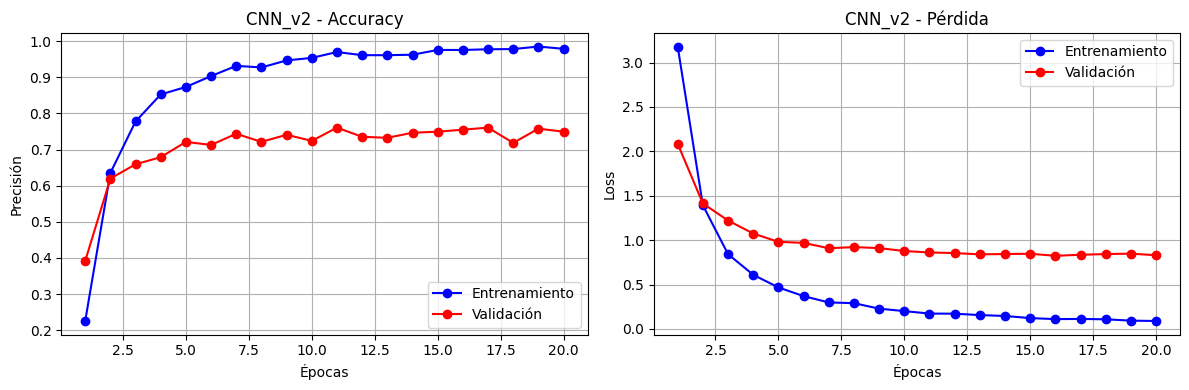

In [9]:
# 📈 Graficar historia de entrenamiento
utils.plot_training_history(history, model_name="CNN_v2")

In [10]:
# ✅ Guardar nombres de clases para uso posterior
with open("class_indices.yaml", "w") as f:
    yaml.dump(train_generator.class_indices, f)